In [2]:
import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [3]:
# Define the directory containing your dataset
data_dir = "D:/vscode/dataset"

# Define the class labels and corresponding directories
class_labels = ["Healthy", "Mild DR", "Moderate DR", "Proliferate DR", "Severe DR"]

# Initialize lists to store image paths and corresponding labels
image_paths = []
labels = []

# Iterate over class labels and directories
for i, label in enumerate(class_labels):
    label_dir = os.path.join(data_dir, label)
    
    # Iterate over files in the label directory
    for file_name in os.listdir(label_dir):
        # Construct the full path to the image file
        file_path = os.path.join(label_dir, file_name)
        
        # Append the image path to the list
        image_paths.append(file_path)
        
        # Append the label index to the labels list
        labels.append(i)  # Using numerical label corresponding to the index of the class label

# Print the number of images and labels
print("Total images:", len(image_paths))
print("Total labels:", len(class_labels))

Total images: 2750
Total labels: 5


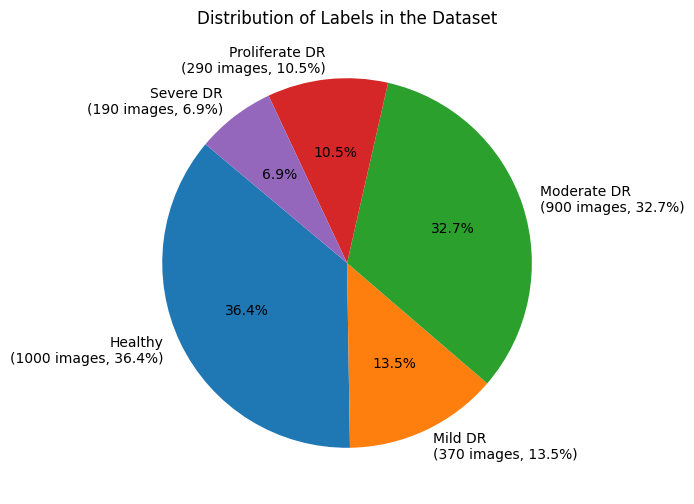

In [4]:
# Define the class labels and corresponding counts
class_labels = ["Healthy", "Mild DR", "Moderate DR", "Proliferate DR", "Severe DR"]
class_counts = [1000, 370, 900, 290, 190]
# Calculate total number of images
total_images = sum(class_counts)

# Calculate percentages
percentages = [(count / total_images) * 100 for count in class_counts]

# Generate labels with counts and percentages
labels_with_percentages = [f"{label}\n({count} images, {percentage:.1f}%)"
                           for label, count, percentage in zip(class_labels, class_counts, percentages)]

# Plotting the pie chart
plt.figure(figsize=(10, 6))
plt.pie(class_counts, labels=labels_with_percentages, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels in the Dataset')
plt.axis('off')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [5]:
# Convert lists to pandas series
img_paths_series = pd.Series(image_paths, name='Image_Path')
labels_series = pd.Series(labels, name='Label')

# Concatenate series into DataFrame
Tr_data = pd.concat([img_paths_series, labels_series], axis=1)

# Display first few rows of the dataframe
print(Tr_data.head())

                                   Image_Path  Label
0       D:/vscode/dataset\Healthy\Healthy.png      0
1    D:/vscode/dataset\Healthy\Healthy_10.png      0
2   D:/vscode/dataset\Healthy\Healthy_100.png      0
3  D:/vscode/dataset\Healthy\Healthy_1000.png      0
4   D:/vscode/dataset\Healthy\Healthy_101.png      0


In [6]:
# Split data into train and test sets (80% train, 20% test)
train_data, test_data = train_test_split(Tr_data, test_size=0.2, random_state=42, stratify=Tr_data['Label'])

# Split train data into train and validation sets (75% train, 25% validation)
train_data, valid_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data['Label'])

# Print shapes of train, valid, and test sets
print("Train set shape:", train_data.shape)
print("Validation set shape:", valid_data.shape)
print("Test set shape:", test_data.shape)

# Print value counts of labels in the training set
print("\nValue counts of labels in the training set:")
print(train_data['Label'].value_counts())

Train set shape: (1650, 2)
Validation set shape: (550, 2)
Test set shape: (550, 2)

Value counts of labels in the training set:
Label
0    600
2    540
1    222
3    174
4    114
Name: count, dtype: int64


In [7]:
train_data['Label'] = train_data['Label'].astype(str)
valid_data['Label'] = valid_data['Label'].astype(str)
test_data['Label'] = test_data['Label'].astype(str)

In [8]:
batch_size = 20   # As smaller, As more data generated ....In views of data size 
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(
    train_data,
    x_col = 'Image_Path',
    y_col = 'Label', 
    target_size = img_size, 
    class_mode = 'categorical', 
    color_mode = 'rgb', 
    shuffle = True, 
    batch_size = batch_size)

Valid = V_G.flow_from_dataframe(
    valid_data, 
    x_col = 'Image_Path', 
    y_col = 'Label', 
    target_size = img_size, 
    class_mode = 'categorical', 
    color_mode = 'rgb', 
    shuffle = True, 
    batch_size = batch_size)

Test = t_G.flow_from_dataframe(
    test_data,
    x_col = 'Image_Path', 
    y_col = 'Label', 
    target_size = img_size, 
    class_mode = 'categorical', 
    color_mode = 'rgb', 
    shuffle = False, 
    batch_size = batch_size)

Found 1650 validated image filenames belonging to 5 classes.


Found 550 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


In [9]:
# Print unique labels present in the dataset
unique_labels = Tr_data['Label'].unique()
print("Unique labels in the dataset:", unique_labels)

# Print count of images for each label category
print("\nCount of images for each label category:")
print(Tr_data['Label'].value_counts())


Unique labels in the dataset: [0 1 2 3 4]

Count of images for each label category:
Label
0    1000
2     900
1     370
3     290
4     190
Name: count, dtype: int64


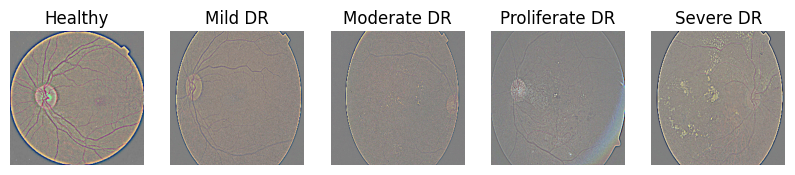

In [10]:
# Mapping between numeric labels and their corresponding names
label_names = {
    0: "Healthy",
    1: "Mild DR",
    2: "Moderate DR",
    3: "Proliferate DR",
    4: "Severe DR"
}

# Create a figure to display the sample images
plt.figure(figsize=(10, 8))

# Iterate over each label category
for label in unique_labels:
    # Filter data for the current label
    label_data = Tr_data[Tr_data['Label'] == label]
    
    # Select the first image from the filtered data
    sample_image = label_data.iloc[0]['Image_Path']
    
    # Load and display the sample image
    image = plt.imread(sample_image)
    plt.subplot(1, len(unique_labels), label + 1)
    plt.imshow(image)
    
    # Get the name of the label using the mapping
    label_name = label_names[label]
    
    plt.title(label_name)
    plt.axis('off')

# Show the plot
plt.show()

In [11]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB2

# Load the pre-trained EfficientNetB2 model without the top (classification) layer
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)  # 5 output classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 7,949,566 (30.33 MB)

 Trainable params: 180,997 (707.02 KB)

 Non-trainable params: 7,768,569 (29.63 MB)

In [12]:
# Get the number of layers in the model
num_layers = len(model.layers)

# Print the number of layers
print("Number of layers in the model:", num_layers)

Number of layers in the model: 343


In [13]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))

In [14]:
model.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [15]:
model.build((None, 224, 224, 3))

In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming your DataFrame is named Tr_data
# Extracting image paths and labels from the DataFrame
image_paths = Tr_data['Image_Path'].values
labels = Tr_data['Label'].values

# Load and preprocess images
images = []
for path in image_paths:
    # Load image
    img = load_img(path, target_size=(224, 224))
    # Convert image to array
    img_array = img_to_array(img)
    # Preprocess the image (e.g., normalization)
    # img_array = preprocess_input(img_array)  # You may need to normalize the image
    images.append(img_array)

# Convert list to numpy array
images = np.array(images)

# Now you can call the model on the preprocessed images
predictions = model.predict(images)


86/86 ━━━━━━━━━━━━━━━━━━━━ 86s 910ms/step


In [17]:
epochs = 40
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - acc: 0.4842 - loss: 1.8714 - val_acc: 0.6727 - val_loss: 0.8806
Epoch 2/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - acc: 0.6760 - loss: 0.8620 - val_acc: 0.7091 - val_loss: 0.7952
Epoch 3/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - acc: 0.7079 - loss: 0.7554 - val_acc: 0.7200 - val_loss: 0.7938
Epoch 4/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - acc: 0.7103 - loss: 0.7787 - val_acc: 0.7000 - val_loss: 0.7585
Epoch 5/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - acc: 0.7381 - loss: 0.6938 - val_acc: 0.7073 - val_loss: 0.7895
Epoch 6/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - acc: 0.7288 - loss: 0.7058 - val_acc: 0.7109 - val_loss: 0.7976
Epoch 7/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - acc: 0.7445 - loss: 0.6439 - val_acc: 0.6927 - val_loss: 0.8332
Epoch 8/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - acc: 0.7768 - loss: 0.5935 - val_acc: 0.7255 - val_loss: 0.7359
Epoch 9/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - acc: 0.7697 - loss:

In [18]:
# accuracy and loss of Train
tr_acc = history.history['acc']
tr_loss = history.history['loss']

# accuracy and loss or Valid\
v_acc = history.history['val_acc']
v_loss = history.history['val_loss']

# highest value of v_acc by getting its index
index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]

# lowest value of v_loss by getting index
index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]

# n. of epochs based on length of tr_acc values
Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)
    
# Define best epoch
best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

In [22]:
model.save('D:/vscode/efficientnet.keras')

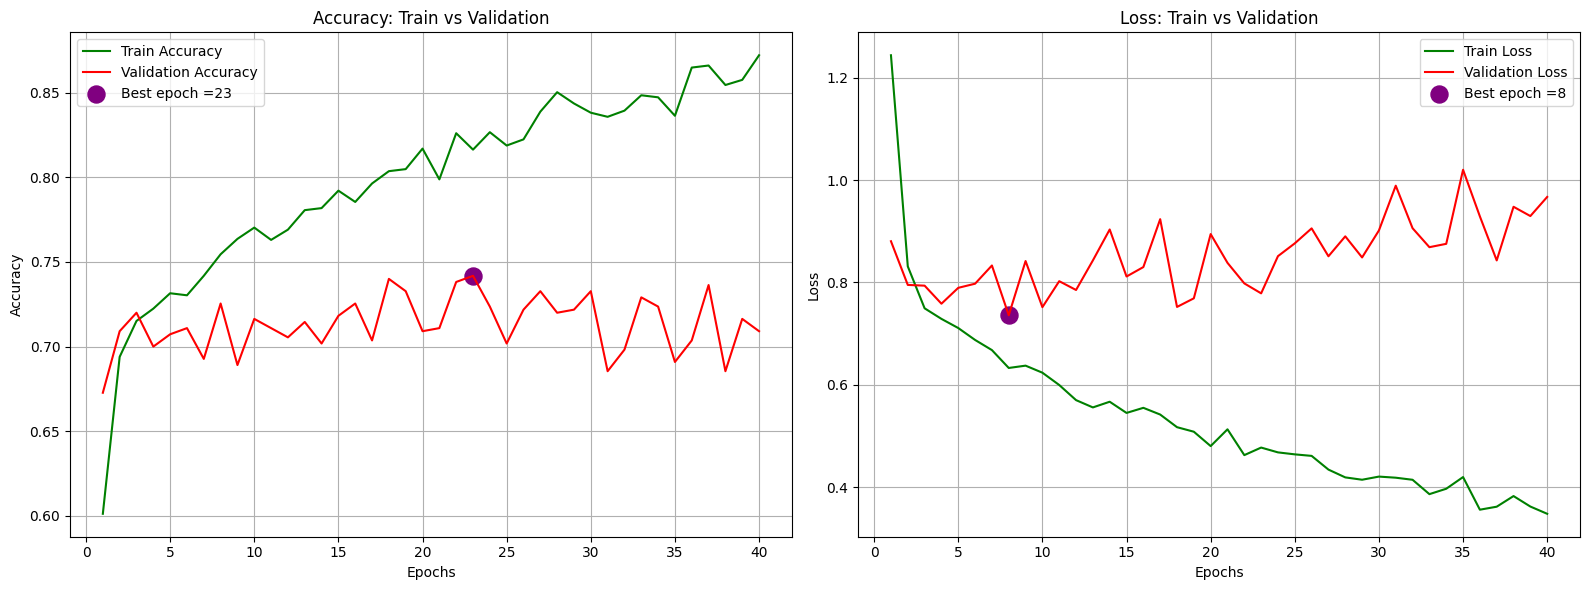

In [23]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_acc, color='green', label=f'Train Accuracy')
plt.plot(Epochs, v_acc, color='red', label=f'Validation Accuracy')
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)
plt.title('Accuracy: Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_loss, color='green', label=f'Train Loss')
plt.plot(Epochs, v_loss, color='red', label=f'Validation Loss')
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)
plt.title('Loss: Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [24]:
Train_sc = model.evaluate(Train, verbose = 1)
Valid_sc = model.evaluate(Valid, verbose = 1)
Test_sc =model.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0])
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0])
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0])

83/83 ━━━━━━━━━━━━━━━━━━━━ 61s 730ms/step - acc: 0.8960 - loss: 0.2635
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 602ms/step - acc: 0.7091 - loss: 0.9830
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 600ms/step - acc: 0.7480 - loss: 0.8896
Train Scores : 
    accuracy: 0.8993939161300659 
      Loss:  0.2534492313861847
Valid Scores : 
    accuracy: 0.7090908885002136 
      Loss:  0.9770010709762573
Test Scores : 
    accuracy: 0.7236363887786865 
      Loss:  0.9867572784423828


In [25]:
predictions = model.predict(Test)
y_pred = np.argmax(predictions, axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 727ms/step


In [26]:
report = classification_report(Test.classes, y_pred, target_names=class_labels)

# Print the classification report
print(report)

                precision    recall  f1-score   support

       Healthy       0.91      0.97      0.94       200
       Mild DR       0.55      0.72      0.62        74
   Moderate DR       0.62      0.77      0.69       180
Proliferate DR       0.83      0.09      0.16        58
     Severe DR       0.60      0.16      0.25        38

      accuracy                           0.72       550
     macro avg       0.70      0.54      0.53       550
  weighted avg       0.74      0.72      0.69       550



In [27]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices
 
# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[195,   3,   2,   0,   0],
       [  6,  53,  15,   0,   0],
       [ 12,  26, 139,   1,   2],
       [  0,  11,  40,   5,   2],
       [  1,   3,  28,   0,   6]], dtype=int64)

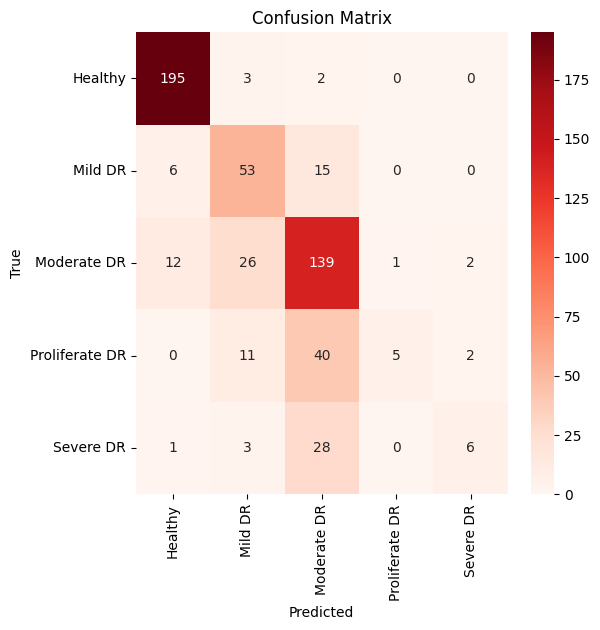

In [28]:
# Create confusion matrix
cm = confusion_matrix(Test.classes, y_pred)

# Define class labels
class_labels = ["Healthy", "Mild DR", "Moderate DR", "Proliferate DR", "Severe DR"]

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()